<a href="https://colab.research.google.com/github/papipopapu/PhysicsThings/blob/main/FluidSym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import numba as nb
import typing as tp
import math

In [6]:
from scipy.interpolate import RectBivariateSpline 
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation 
from matplotlib import rcParams

In [87]:

@nb.njit()
def noForceI(v: np.array, t: float, dt: float):
  v += 50 * dt
  return v

@nb.njit()
def noForceJ(u: np.array, t: float, dt: float):
  u += 5 * np.sin(t * np.ones(u.shape))

  return u

@nb.njit()
def noInk(ink: np.array, t: float, dt: float):
  ink[50:55, 50:55] += dt
  return ink


@nb.njit([nb.float64[:,:](nb.float64[:,:], nb.float64), nb.float32[:,:](nb.float32[:,:], nb.float32)])
def Dx(Field: np.array, dh: float): # its trimmed specially to be added to velocities in x
  Dx = Field[:, 1:] - Field[:, :-1]

  return Dx/dh


@nb.njit([nb.float64[:,:](nb.float64[:,:], nb.float64), nb.float32[:,:](nb.float32[:,:], nb.float32)])
def Dy(Field: np.array, dh: float): # its trimmed specially to be added to velocities in y
  Dy = Field[1:, :] - Field[:-1, :]

  return Dy/dh


@nb.njit()
def Laplacian(Field: np.array, dh: float): 
  dx1 = Dx(Field[1:-1, :], dh)
  dy1 = Dy(Field[:, 1:-1], dh)
  dx2 = Dx(dx1, dh)
  dy2 = Dy(dy1, dh)

  return dx2 + dy2


class fluidThings:
  def __init__(self, Ni: int, Nj: int, dh: float, forceSourceI = noForceI, forceSourceJ = noForceJ, inkSource = noInk, alpha = 0.01, ka = 0.1, rho = 1, visc = 1, beta = 0.1): # add you source functions, arguments above
    self._beta = beta
    self._visc = visc
    self._forceSourceJ = forceSourceJ
    self._forceSourceI = forceSourceI
    self._inkSource = inkSource
    self._time = 0
    self._Ni = Ni # Number of fluid cells on a dimension
    self._Nj = Nj
    self._dh = dh # Size of a cell 
    self._dt = 0.1
    self._ka = ka
    self._alpha = alpha
    self._rho = rho
    self._Kp = rho * dh * dh # useful thing

    umgrid = np.mgrid[0:Ni, 0:Nj + 1]
    vmgrid = np.mgrid[0:Ni + 1, 0:Nj]
    smgrid = np.mgrid[0:Ni + 2, 0:Nj + 2]


    self._u = np.zeros((Ni, Nj+1)) # Field of vx velocities in walls (named u), to zeros when we can initialize initial conditions with method
    self._uSpline = RectBivariateSpline(np.arange(Ni), np.arange(Nj+1), self._u) # Smooth interpolation
   # print (self._u ) # to remove check

    self._uPos =  fluidThings.uPos(np.vstack((umgrid[0].flatten(), umgrid[1].flatten())), Ni, dh)        
    #print (self._uPos)

    self._v = np.zeros((Ni+1, Nj)) # Field of vy velocities in walls (named v)
    self._vSpline = RectBivariateSpline(np.arange(Ni+1), np.arange(Nj), self._v)
   # print (self._v )

    self._vPos =  fluidThings.vPos(np.vstack((vmgrid[0].flatten(), vmgrid[1].flatten())), Ni, dh)  


    self._p = np.arange((Ni)*(Nj)).reshape(Ni, Nj)
    #self._pSpline = RectBivariateSpline(np.arange(Ni+2), np.arange(Nj+2), self._p) 
  #  print (self._p )

    # in general, we also define scalars inside solid cells, but we dont need to do it for pressure
    self._ink = np.zeros((Ni+2, Nj+2))
    self._inkSpline = RectBivariateSpline(np.arange(Ni+2), np.arange(Nj+2), self._ink) # zero on solid cell walls?
   # print (self._ink ) # to remove check

    self._sPos =  fluidThings.sPos(np.vstack((smgrid[0].flatten(), smgrid[1].flatten())), Ni, dh)  

    diags = fluidThings.diagsA(Ni, Nj)
    pos = np.array([-Nj, -1, 0, 1, Nj])
    self._sA = scipy.sparse.spdiags(diags, pos, Ni*Nj, Ni*Nj, format = 'csr')


  @staticmethod
  @nb.njit()
  def diagsA(Ni: int, Nj: int):
    Nt = Ni * Nj
    diags = np.zeros((5, Ni*Nj)) #[[top], [left], [mid], [right], [down]]
    top = np.zeros(Nt)
    left = np.zeros(Nt)
    mid = np.zeros(Nt)
    right = np.zeros(Nt)
    down = np.zeros(Nt)
    k = 0
    for i in np.arange(Ni):
      for j in np.arange(Nj):
        adjF = 0
        if (i > 0):# theres space on top
          adjF += 1
          top[k] = 1
        if (j > 0):# theres space left
          adjF += 1
          left[k] = 1
        if (i < Ni - 1): # theres space  down
          adjF += 1
          down[k] = 1
        if (j < Nj - 1): # threses space right
          adjF += 1
          right[k] = 1
        mid[k] = -adjF
        k += 1
    diags[0, :Nt-Nj] = top[Nj:]
    diags[4, Nj:] = down[:Nt-Nj]
    diags[1, :Nt-1] = left[1:]
    diags[3, 1:] = right[:Nt-1]
    diags[2, :] = mid
  
    
    
    
   

    return diags

    
  


  @staticmethod
  @nb.njit()
  def uIdx(r: np.array, Ni: int, dh: float): # idx = [[ui],[uj]], this functions gets x,y and returns indices for u 
    idx = np.zeros((2, r[0].size));
    xScaled = r[0]/dh 
    yScaled = r[1]/dh

    idx[0] = -yScaled + Ni - 0.5 # u_i
    idx[1] = xScaled # u_j


    return idx

  @staticmethod
  @nb.njit()
  def vIdx(r: np.array, Ni: int, dh: float): # idx = [[vi],[vj]], this functions gets x,y and returns indices for v
    idx = np.zeros((4, r[0].size));
    xScaled = r[0]/dh 
    yScaled = r[1]/dh

    idx[0] = -yScaled + Ni # v_i
    idx[1] = xScaled - 0.5 # v_j

    return idx

    
  @staticmethod
  @nb.njit()
  def sIdx(r: np.array, Ni: int, dh: float): # idx = [[si],[sj]] , for ink or pressure
    idx = np.zeros((2, r[0].size));

    idx[0] = Ni - r[1]/dh + 0.5 # u_j
    idx[1] = r[0]/dh + 0.5

    return idx
  
  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def uPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0] - 0.5) * dh # y
    r[0] = idx[1] * dh # x

    return r

  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def vPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0]) * dh # y
    r[0] = (idx[1] + 0.5) * dh # x

    return r

  @staticmethod
  @nb.njit() # now we give idx and get position xy
  def sPos(idx: np.array, Ni: int, dh: float):
    r = np.zeros((2, idx[0].size))

    r[1] = (Ni - idx[0] + 0.5) * dh # y
    r[0] = (idx[1] - 0.5) * dh # x

    return r

  

  @staticmethod
  @nb.njit()
  def dtGet(u: np.array, v: np.array, dh: float):
    mod = u[:, 1:] ** 2 + v[1:, :] ** 2 # not quite but idk besiuñagt
    maxu = np.amax(mod)
    dt = max(5 * dh / (math.sqrt(maxu) + 1e-7), 0.01)
    return dt

  def fu(self, r: np.array): # r = [[x],[y]], return u
    idx = self.uIdx(r, self._Ni, self._dh); # get indices
    u = self._uSpline.ev(idx[0], idx[1]) # interpolate
    return u

  def fv(self, r: np.array): # r = [[x],[y]], return v
    idx = self.vIdx(r, self._Ni, self._dh); # get indices
    v = self._vSpline.ev(idx[0], idx[1]) # interpolate 
    return v

  def fp(self, r: np.array): # return [p]
    idx = self.sIdx(r, self._Ni, self._dh); # get indices
    p = self._pSpline.ev(idx[0], idx[1])

    return p

  def fink(self, r: np.array): # return [ink]
    idx = self.sIdx(r, self._Ni, self._dh); # get indices
    ink = self._inkSpline.ev(idx[0], idx[1])

    return ink

  def backHeun(self, r: np.array): # r = [[x], [y]] 
    umid = np.vstack((self.fu(r), self.fv(r)))
    rmid = r - self._dt * umid
    rn = r - self._dt * 0.5 * (umid + np.vstack((self.fu(r), self.fv(r))))

    return rn

  def updateSplines(self):
    self._uSpline = RectBivariateSpline(np.arange(self._Ni), np.arange(self._Nj+1), self._u) 
    self._vSpline = RectBivariateSpline(np.arange(self._Ni+1), np.arange(self._Nj), self._v) 
    self._inkSpline = RectBivariateSpline(np.arange(self._Ni+2), np.arange(self._Nj+2), self._ink)

  def addSources(self):
    self._u = self._forceSourceJ(self._u, self._time, self._dt) 
    self._v = self._forceSourceI(self._v, self._time, self._dt)
    self._ink = self._inkSource(self._ink, self._time, self._dt)

  def enforceBounds(self):
    self._u[:, 0] = 0; self._u[:, self._Nj] = 0
    self._v[0, :] = 0; self._v[self._Ni, :] = 0
    self._ink[0, :] = 0; self._ink[self._Ni+1, :] = 0; self._ink[:, 0] = 0; self._ink[:, self._Nj+1] = 0
  
  def advectAll(self):
    tempu = (self.fu( self.backHeun (self._uPos) )).reshape(self._Ni , self._Nj + 1) # Advect velocities
    tempv = (self.fv( self.backHeun (self._vPos) )).reshape(self._Ni + 1, self._Nj)
    self._ink = (self.fink( self.backHeun (self._sPos) )).reshape(self._Ni+2, self._Nj+2) # Advect ink
    self._u = tempu
    self._v = tempv

  def diffAndDissInk(self):
    self._ink[1:-1, 1:-1] += self._dt * self._ka * Laplacian(self._ink, self._dh) # missing conserve ink
    self._ink -= self._dt * self._alpha * self._ink

  def initialConditions(self, u: np.array, v: np.array, p: np.array, ink: np.array,  dt: float):
    self._dt = dt
    self._u = u
    self._v = v
    self._p = p
    self._ink = ink
    self.updateSplines()

  def makeIncompressible(self):
    b =  (Dx(self._u, self._dh) + Dy(self._v, self._dh)).flatten()
    Ps = self._Kp * scipy.sparse.linalg.spsolve(self._sA, b)
    self._p = Ps.reshape(self._Ni, self._Nj)
    self._u[:, 1:-1] -= Dx(self._p, self._dh)/self._rho
    self._v[1:-1, :] -= Dy(self._p, self._dh)/self._rho



  
  def step(self):

    # self._dt = fluidThings.dtGet(self._u, self._v, self._dh) # get time step
    # Add forces and sources
    self.addSources()

    # Enforce boundaries
    self.enforceBounds()

    # Update splines
    self.updateSplines()

    # Advect
    self.advectAll()

    # Diffuse and dissipate ink
    self.diffAndDissInk()

    # Missing: diffuse velocities, 
    

    # Make incompressible
    self.makeIncompressible()

    #plt.imshow(self._ink, vmin = 0, vmax = 1)
    #print (self._u)
    # Update splines
    self.updateSplines()

    self.advectAll()
    self.updateSplines()
    # ... 
    self._time += self._dt
    

    return self._ink






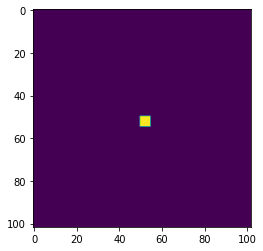

In [88]:
Ni = 100
Nj = 100
fluid = fluidThings(Ni, Nj, 1)
p = np.zeros((Ni, Nj))

u = np.zeros((Ni, Nj+1))
v = np.ones((Ni+1, Nj))*10
ink = np.zeros((Ni+2, Nj+2))
ink[50:55, 50:55] = 1
plt.imshow(ink, vmin = 0, vmax = 1)

fluid.initialConditions(u, v, p, ink, 0.1)

In [84]:
fluid.step()

array([[ 6.54620251e-74,  9.24918310e-70, -6.08764380e-70, ...,
         1.06088807e-67,  4.75233823e-69,  0.00000000e+00],
       [ 2.57248558e-69, -5.79939818e-55,  1.57571984e-54, ...,
         9.50880302e-53, -2.99972361e-53,  0.00000000e+00],
       [-9.38564917e-69,  2.11252136e-54, -5.73973768e-54, ...,
        -3.46368945e-52,  1.09268990e-52,  0.00000000e+00],
       ...,
       [ 4.53530518e-69, -7.54408520e-55,  2.04980076e-54, ...,
         1.23696781e-52, -3.90219763e-53,  0.00000000e+00],
       [-2.88848410e-69,  6.21622759e-55, -1.68942389e-54, ...,
        -1.01949296e-52,  3.21574321e-53,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [85]:
fluid._u

array([[-1.10405967e-17, -2.17603713e-14, -1.15463195e-14, ...,
         1.95954364e-14,  1.75415238e-14,  0.00000000e+00],
       [-9.36305264e-18, -1.75415238e-14, -3.04201109e-14, ...,
        -2.38142839e-14,  1.38777878e-14,  0.00000000e+00],
       [-1.83236069e-18,  3.14193116e-14, -6.91668944e-14, ...,
         3.68594044e-14, -1.25455202e-14,  0.00000000e+00],
       ...,
       [-6.83006518e-18, -9.43689571e-16,  6.11732887e-14, ...,
        -7.39408534e-14,  4.18554080e-14,  0.00000000e+00],
       [-1.72653252e-18, -1.53765889e-14,  5.88418203e-15, ...,
         4.13558077e-14, -2.44249065e-15,  0.00000000e+00],
       [-3.11225573e-18, -1.79856130e-14,  5.48450174e-14, ...,
        -2.90323321e-14,  4.26325641e-14,  0.00000000e+00]])

In [86]:
fluid._v

array([[-5.50824873e-17, -2.40041524e-16,  3.23330358e-17, ...,
        -3.43809502e-17, -6.98148451e-17, -1.34811594e-16],
       [ 4.88498131e-14, -8.88178420e-16,  3.55271368e-15, ...,
         1.95399252e-14, -4.44089210e-14, -7.10542736e-15],
       [-3.46389584e-14,  3.64153152e-14, -1.33226763e-14, ...,
        -5.32907052e-14,  1.86517468e-14, -2.48689958e-14],
       ...,
       [-5.32907052e-15, -1.59872116e-14, -2.66453526e-14, ...,
        -6.03961325e-14,  5.32907052e-14,  3.64153152e-14],
       [-4.44089210e-14, -4.92939023e-14, -2.66453526e-15, ...,
         2.79776202e-14, -4.88498131e-14, -2.88657986e-14],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

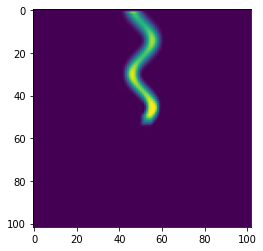

In [89]:


fig = plt.figure()
axis = plt.axes()
def animate(i):
  global fluid
  axis.clear()
  ink = fluid.step()
  image = axis.imshow(ink, vmin = 0, vmax = 1)
  return image
myAnim = animation.FuncAnimation(fig, animate, interval = 50, frames = 200)

f = '/content/drive/MyDrive/Animaciones/test.gif'
writervideo = animation.PillowWriter(fps=30) 

myAnim.save(f, writer = writervideo)

  

